In [1]:
import pymc3 as pm
import math
import pandas as pd
import numpy as np
import theano.tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pickle as pk
from eval_metrics import EvalMetrics
from theano import shared
from pipeline import pipeline
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
from shapely.geometry import box

# Clustering Neighborhoods

---

Defining a neighborhood is complicated and often done qualitatively. Clustering methodologies may provide a way to more specifically define what a neighborhood is. By grouping spatially adjacent areas that also share the same classification, we may define these areas as a neighborhood in which its members are spatially contiguous and share similar features. This will allow city planners to be able to more rigorously define neighborhood boundaries. 

In this notebook we explore bayesian methods to cluster physical areas by socioeconomic features to form a neighborhood. We use a graphical model to clustering having the following variables:
- θ: The model parameters of the underlying distribution that the data centroids have been sampled from. This variable changes depending on the distribution and can assume more than one value (eg: normal distribution having both standard deviation and mean parameters)
- C : a discrete variable drawn from a categorical distribution which signifies the cluster assignment for a particular data point
- W : the weight that represents the weight of a specific category in the Gaussian mixture model. This is a continuous variable drawn from a Dirichlet distribution
- O: the observed socioeconomic census data that is used as evidence in the graphical model
- N : the number of data points (census tracts)
- K: the number of clusters
We will use sampling methods to calculate values of C and θ so we can assign a cluster to an area

The following methods are compared to the graphical model:
- K-Means: clustering based off of minimizing root sum of squares. The draw backs that it are assumes that the data variance is distributed symmetrically. This property is usually not held for real data, as will be demonstrated later in the notebook. It also assumes equal variance and size clusters across the entire data set, which is not true as each feature is distributed differently
- Max-P: an optimization model which attempts to group n-areas into a maximum number (p) regions while satisfying a threshold constraint and minimize heterogeneity within the groups and including spatial proximity constraints. The main drawback is the choice of the minimum number of areas per region, since region (neighborhood) sizes change across different neighborhoods

## Graphical Model Testing

In order to ensure that the graphical model able to generate valid clusters, we created a set of artificial data that is completely seperable and used it to train the model

In [4]:
metric_names = ['a18und', 'a60up', 'nhwht', 'nhblk', 'hisp', 'unemp', 'fb', 'col', 'manuf', 'own', 'vac', 'hinc', 'mrent', 'mhmval']

In [56]:
# Function to determine purity
def neighborhood_purity(df, nhood_col, cluster_col):

    purity = []

    # Iterate through the pre-existing "ground truth" neighborhoods 
    for neighborhood in df[nhood_col].unique():

        # Calculate number of tracts grouped by cluster assignments             
        n_clusters = df.loc[df[nhood_col] == neighborhood].groupby(cluster_col).size()

        # Take the number of tracts with the most frequent cluster and divide by the total number of tracts in the neighborhood
        purity.append(n_clusters.max()/n_clusters.sum())

    return purity

In [2]:
# Function to make artificial data
def make_data(n_clusters, points_per_cluster, noise, metric_names):
    
    # Settings to make a rectangular area that have distinct regions that are easily seperable
    n_across = int(points_per_cluster/14)
    n_down = 14*n_clusters
    minx, miny = 0,0
    maxx, maxy = 1,1
    val = 0
    box_list = []

    # Make the rectangular area and assign values of the true cluster
    for i in range(1, n_down+1):
        for j in range(0, n_across):
            box_list.append([box(minx, miny, maxx, maxy), val])
            minx += 1
            maxx += 1
        miny += 1
        maxy += 1
        minx = 0
        maxx = 1
        if( i%14 == 0 ):
            val += 1

    eval_df = gpd.GeoDataFrame(box_list, columns=['geometry', 'true_cluster'])
    
    n_dimensions = len(metric_names)
    data = []

    # For each spatial segment, generate a set of distinct means using a noise factor
    for i in range(0, n_clusters):

        mu = 15+15*i*np.ones(n_dimensions)

        for j in range(0,points_per_cluster):
            rand = np.random.normal(loc=mu, scale=15*(noise/10)).tolist()
            data.append(rand)

    data = np.array(data)

    for i in range(0, n_dimensions):
        eval_df[metric_names[i]] = data[:,i]
    
    return eval_df

Plot the map to ensure that the areas are distinct

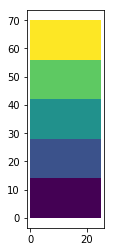

In [6]:
make_data(5, 350, 0, metric_names).plot(column='true_cluster')
plt.show()

### Graphical Model One: No constraints

For the following graphical models, I am going to use 5 clusters as many research papers have used 5-8 clusters.

In [7]:
n_clusters = 5
points_per_cluster = 350
noise = 0
metric_names = ['a18und', 'a60up', 'nhwht', 'nhblk', 'hisp', 'unemp', 'fb', 'col', 'manuf', 'own', 'vac', 'hinc', 'mrent', 'mhmval']

In [8]:
# Function to create clusters based on highest frequency
def create_clusters(tr, ndata):

    cluster, certainty = [], []

    for i in range(0, ndata):
        # Get the category predictions for each area and choose the most frequent one
        a = tr['category'][:,i]
        counts = np.bincount(a)
        cluster.append(np.argmax(counts))
        certainty.append(np.max(counts)/np.sum(counts))

    return cluster, certainty

In [15]:
df = make_data(n_clusters, points_per_cluster, noise, metric_names)

data = df[metric_names].values

# Get basic stats of the data in order to form the graphical model
lower = np.amin(data, axis=0)
upper = np.amax(data, axis=0)
mid = (upper-lower)/2
std = data.std()
data_dim = data.shape[1]
ndata = data.shape[0]

# Setup model
model = pm.Model()
with model:

    # Cluster weights
    w = pm.Dirichlet('w', a=np.ones(n_clusters), shape=n_clusters)

    # Ensure that each cluster has some assignments
    w_min_potential = pm.Potential('w_min_potential', tt.switch(tt.min(w) < 0.1, -np.inf, 0))

    # Assume the cluster centers come from a normal distriubtion
    mu = pm.Normal('mu', mu=mid, sd=std, shape=(n_clusters, data_dim))

    std = pm.Uniform('sd', 0, 20, shape=data_dim)
    
    # Latent cluster of each observation
    category = pm.Categorical('category',
                              p=w,
                              shape=ndata)

    # Likelihood for each observed value
    points = pm.Normal('obs',
                       mu=mu[category],
                       sd=std,
                       observed=data)

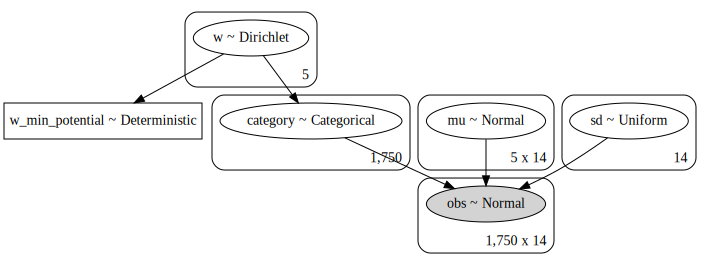

In [18]:
pm.model_to_graphviz(model)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sd, mu, w]
>CategoricalGibbsMetropolis: [category]
Sampling 4 chains: 100%|██████████| 6000/6000 [15:44<00:00,  1.69draws/s]
There were 983 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
There were 970 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.03542266836921917, but should be close to 0.8. Try to increase the number of tuning steps.
There were 356 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6178345475558228, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameter

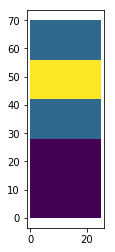

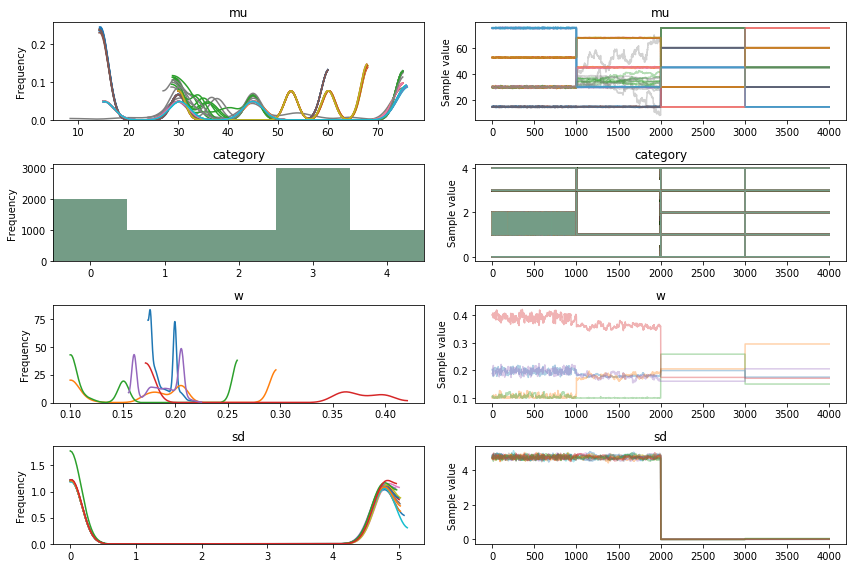

In [21]:
# Run the sampler
with model:
    tr = pm.sample(1000, chains=4, tune=500, cores=4, target_accept=0.99)
    
# Get the cluster assignment and the certainty of that assignment
cluster, certainty = create_clusters(tr, ndata)
df['gm_cluster'] = cluster

# Plot the results, must be 5 distinct regions
df.plot(column='gm_cluster')
plt.show()

# Plot the trace plot
pm.plots.traceplot(tr, combined=True)
plt.show()

As seen in the map, the model was classifying only 3 clusters as opposed to 5, the prespecified number. These issues are due the sampler switching between means for an assigned cluster as it continues to run (see traceplot)

### Graphical Model Two: Gaussian Means

In order to make the samplers not switch means, while not enforcing a hard constraints, we use the following techique: for the first dimension and first cluster, generate "mu" normally. Then for the second cluster, first dimension, generate "mu" using the a mean that is generated by taking the midpoint of the previously generated mean and the max value for that dimension in the data set. This should encourage the sampler not to switch, while not enforcing a hard constraint, which could get the sampler to get stuck in an area of low probability 

In [29]:
df = make_data(n_clusters, points_per_cluster, noise, metric_names)

# Get basic stats of the data in order to form the graphical model
lower = np.amin(data, axis=0)
upper = np.amax(data, axis=0)
mid = (upper-lower)/2
std = data.std(axis=0)
ndata = len(data)
data_dim = data.shape[1]
    
# Setup model
model = pm.Model()
with model:

    # Cluster weights
    w = pm.Dirichlet('w', a=np.ones(n_clusters), shape=n_clusters) # it is the p above with alpha = [1,1,1]

    # Ensure that each cluster has some assignments
    w_min_potential = pm.Potential('w_min_potential', tt.switch(tt.min(w) < 0.19, -np.inf, 0))
    
    # Create a dict to store the means
    mean_dict = {}

    # Calculate the stats of the first dimension
    sd_dim_0 = (upper[0] - lower[0]) / (5*math.sqrt(3))
    mu_dim_0 = pm.Normal('mu_dim_0_0', mu=mid[0], sd=sd_dim_0)
    
    # Don't change the means of the other dimensions, only need to enforce constraints on one
    mu = pm.Normal('mu_0', mu=mid[1:14], sd=std[1:14], shape=13)
    
    # Combine the dimension 0 and rest of the means into one list, for the first cluster
    mu_list = []
    mu_list.append(mu_dim_0)
    for j in range(0,13):
        mu_list.append(mu[j])
    
    # Use stack to save the means of the first cluster
    mean_dict['mu_0'] = tt.stack(mu_list)
    
    # Iterate through the rest of the clusters
    for i in range(1,n_clusters):
    
        # Dynamically set the keys
        key = 'mu_' + str(i)
        key_mu = 'mu_dim_0_' + str(i)
    
        # Calculate the new value of dimension 0 using the previous value
        prev_val = mean_dict['mu_0'][0]
        mid_new = (upper[0]-prev_val)/2
        sd_dim_0 = (upper[0] - prev_val) / (5*math.sqrt(3))
        mu_dim_0 = pm.Normal(key_mu, mu=mid_new, sd=sd_dim_0)
    
        # Combine the two and append it to the dict
        mu_list = []
        mu_list.append(mu_dim_0)
        for j in range(0,13):
            mu_list.append(mu[j])

        mean_dict[key] = tt.stack(mu_list)
    
    # Append everything in the dict to use as the final variable
    mu_final_list = []
    for key in mean_dict:
        mu_final_list.append(mean_dict[key])
    mu_final = tt.stack(mu_final_list)

    # Latent cluster of each observation
    category = pm.Categorical('category',
                              p=w,
                              shape=ndata)

    # Likelihood for each observed value, fix the standard deviation, because it gives inconsistent results 
    # otherwise
    points = pm.Normal('obs',
                       mu=mu_final[category],
                       sd=5,
                       observed=data)

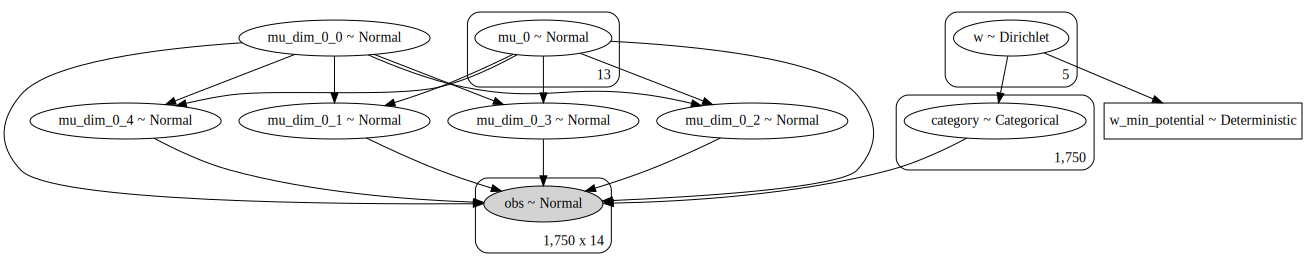

In [35]:
# Display the graphical model
pm.model_to_graphviz(model)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu_dim_0_4, mu_dim_0_3, mu_dim_0_2, mu_dim_0_1, mu_0, mu_dim_0_0, w]
>CategoricalGibbsMetropolis: [category]
Sampling 4 chains: 100%|██████████| 6000/6000 [09:04<00:00,  2.89draws/s]
There were 991 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.572941422634606, but should be close to 0.8. Try to increase the number of tuning steps.
There were 998 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9279649821535557, but should be close to 0.8. Try to increase the number of tuning steps.
There were 985 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated numbe

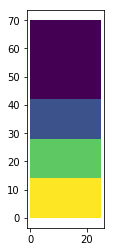

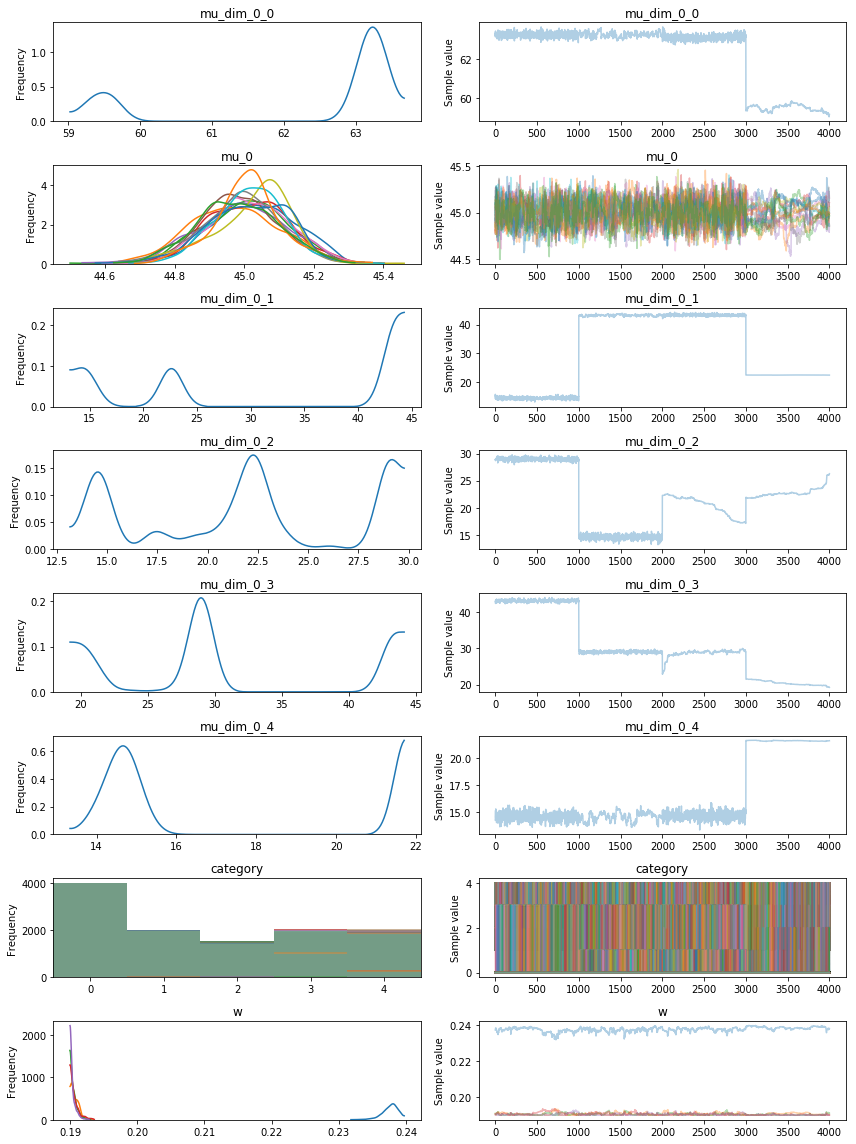

In [36]:
# Run the sampler
with model:
    tr = pm.sample(1000, chains=4, tune=500, cores=4, target_accept=0.99)

# Get the cluster assignment and the certainty of that assignment
cluster, certainty = create_clusters(tr, ndata)
df['gm_cluster'] = cluster

# Plot the results, must be 5 distinct regions
df.plot(column='gm_cluster')
plt.show()

# Plot the trace plot
pm.plots.traceplot(tr, combined=True)
plt.show()

Even with the soft constraints, the sampler still switches means during sampling. Therefore I enforce the strict ordering of means in the following cell

### Graphical Model Three: Hard Constraints

Use the pm.Potential function to assign potentials of Negative Infinity (impossible) to certain outcomes to ensure that the means are ordered and so they will not switch

In [38]:
# Function to make a potential function that enforces ordering
def make_potential(n_clusters, mu):
    
    order_means_potential = tt.switch(mu[0][0] > mu[1][0], -np.inf, 0)
    
    for i in range(1, n_clusters-1):
        order_means_potential += tt.switch(mu[i][0] > mu[i+1][0], -np.inf, 0)
        
    return order_means_potential

In [40]:
data = df[metric_names].values

# Get descriptive stats of the data for later use in the model
lower = np.amin(data, axis=0)
upper = np.amax(data, axis=0)
mid = (upper-lower)/2
std = data.std()
data_dim = data.shape[1]
ndata = data.shape[0]

# Get empirical means of the data, not including the first column
emp_means = data[:,1:14].mean(axis=0)

# Make the first column in a strictly increasing order that spans the range of the column 
dim_0_init = np.linspace(7, upper[0]-lower[0], n_clusters+1)
mu_init = []

# Combine the empircal means and the means of the ordered first column to serve as an initial starting point
for i in range(0, n_clusters):
    temp_list = [dim_0_init[i]]
    temp_list.extend(emp_means)
    mu_init.append(temp_list)

# Setup model
model = pm.Model()
with model:

    # Cluster weights
    w = pm.Dirichlet('w', a=np.ones(n_clusters), shape=n_clusters)

    # Ensure that each cluster has some assignments
    w_min_potential = pm.Potential('w_min_potential', tt.switch(tt.min(w) < 0.1, -np.inf, 0))

    # Normal prior that uses the initial values, otherwise this method does not work
    mu = pm.Normal('mu', mu=mid, sd=std, shape=(n_clusters, data_dim), testval=mu_init)

    # Ensure that means are ordered
    order_means_potential = pm.Potential('order_means_potential', make_potential(n_clusters, mu))

    # Latent cluster of each observation
    category = pm.Categorical('category',
                              p=w,
                              shape=ndata)

    # Likelihood for each observed value
    points = pm.Normal('obs',
                       mu=mu[category],
                       sd=std.mean(),
                       observed=data)

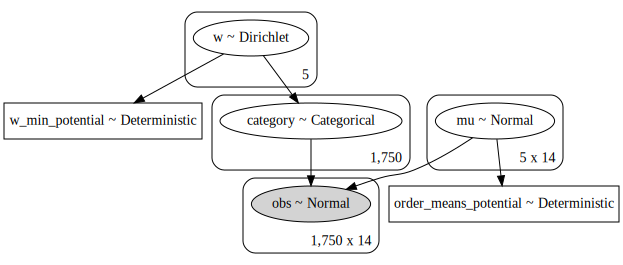

In [41]:
# Display the graphical model
pm.model_to_graphviz(model)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, w]
>CategoricalGibbsMetropolis: [category]
Sampling 4 chains: 100%|██████████| 12000/12000 [14:38<00:00,  6.92draws/s]
The chain contains only diverging samples. The model is probably misspecified.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


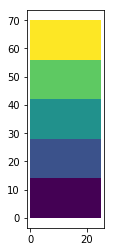

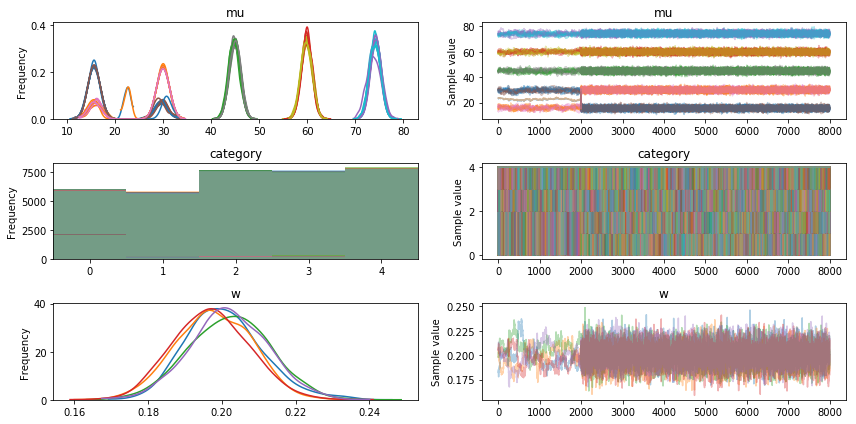

In [43]:
# Run the sampler
with model:
    tr = pm.sample(2000, chains=4, tune=1000, cores=4, target_accept=0.99)
    
# Get the cluster assignment and the certainty of that assignment
cluster, certainty = create_clusters(tr, ndata)
df['gm_cluster'] = cluster

# Plot the results, must be 5 distinct regions
df.plot(column='gm_cluster')
plt.show()

# Plot the trace plot
pm.plots.traceplot(tr, combined=True)
plt.show()

## Model Comparison

The graphical model was then compared to the Max-P and K-Means methods. Since we have the true cluster assignment, we use purity to compare the results. We adjust the noise level of the data, as well as the number of clusters to see which model performs the best

### Graphical Model Testing

In [44]:
# Create a function to test
def test_gm_mean_ordering(df, n_clusters, metric_names):

    data = df[metric_names].values
    
    # Get descriptive stats of the data for later use in the model
    lower = np.amin(data, axis=0)
    upper = np.amax(data, axis=0)
    mid = (upper-lower)/2
    std = data.std()
    data_dim = data.shape[1]
    ndata = data.shape[0]

    # Get empirical means of the data, not including the first column
    emp_means = data[:,1:14].mean(axis=0)
    
    # Make the first column in a strictly increasing order that spans the range of the column 
    dim_0_init = np.linspace(7, upper[0]-lower[0], n_clusters+1)
    mu_init = []

    # Combine the empircal means and the means of the ordered first column to serve as an initial starting point
    for i in range(0, n_clusters):
        temp_list = [dim_0_init[i]]
        temp_list.extend(emp_means)
        mu_init.append(temp_list)

    # Setup model
    model = pm.Model()
    with model:

        # Cluster weights
        w = pm.Dirichlet('w', a=np.ones(n_clusters), shape=n_clusters)

        # Ensure that each cluster has some assignments
        w_min_potential = pm.Potential('w_min_potential', tt.switch(tt.min(w) < 0.1, -np.inf, 0))

        # Normal prior that uses the initial values, otherwise this method does not work
        mu = pm.Normal('mu', mu=mid, sd=std, shape=(n_clusters, data_dim), testval=mu_init)

        # Ensure that means are ordered
        order_means_potential = pm.Potential('order_means_potential', make_potential(n_clusters, mu))

        # Latent cluster of each observation
        category = pm.Categorical('category',
                                  p=w,
                                  shape=ndata)

        # Likelihood for each observed value
        points = pm.Normal('obs',
                           mu=mu[category],
                           sd=std.mean(),
                           observed=data)
        
        # Run the sampler
        tr = pm.sample(2000, chains=4, tune=1000, cores=4, target_accept=0.99, progressbar=False)
    
    # Get the cluster assignment and the certainty of that assignment
    cluster, certainty = create_clusters(tr, ndata)
    df['gm_cluster'] = cluster

    # Calculate purity
    purity = neighborhood_purity(df, 'gm_cluster', 'true_cluster')
    
    return np.mean(purity), np.mean(certainty)

In [ ]:
cluster_range = range(5,8)
points_per_cluster = 350
results = []
noise_range = range(0, 50, 10)

# Iterate through various noise ranges and clusters, this cell was not run as it was run previously as the results
# loaded from a pickle file
for n in cluster_range:
    
    for noise in noise_range:
        
        eval_df = make_data(n, points_per_cluster, noise, metric_names)
        purity, certainty = test_gm_mean_ordering(eval_df, n, metric_names)
        
        results.append([n, noise, purity])

# pk.dump( results, open( 'gm_mean_ordering_results', "wb" ) )
results = pk.load( open( "gm_mean_ordering_results", "rb" ) )
pd.DataFrame(results, columns=['Number of Clusters', 'Noise', 'Purity'])

In [45]:
results = pk.load( open( "gm_mean_ordering_results", "rb" ) )
pd.DataFrame(results, columns=['Number of Clusters', 'Noise', 'Purity'])

,Number of Clusters,Noise,Purity
0,5,0,1.000000
1,5,10,0.517529
2,5,20,0.467138
3,5,30,0.247989
4,5,40,0.287959
5,6,0,1.000000
6,6,10,0.272447
7,6,20,0.284786
8,6,30,0.224390
9,6,40,0.329257


### Max-P Testing

In [46]:
from pysal.region.maxp import Maxp
import pysal

/home/ronnie/anaconda3/envs/thesis_bayesian/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [ ]:
points_per_cluster = 350
results = []
noise_range = range(0, 50, 10)
floor = 250

# Iterate through various noise ranges and clusters, this cell was not run as it was run previously as the results
# loaded from a pickle file
for noise in noise_range:

    eval_df = make_data(5, points_per_cluster, noise, metric_names)
    eval_df[['geometry']].to_file('artificial_maxpshapefile.shp')

    w = pysal.queen_from_shapefile(r'artificial_maxpshapefile.shp')
    z = eval_df[metric_names].values
    p = np.ones((w.n,1), float)

    solution = Maxp(w, z, floor=floor, floor_variable=p)

    mappings = solution.area2region
    eval_df['region'] = -1

    for area in mappings:
        eval_df.loc[area, 'region'] = mappings[area]

    # Calculate purity
    purity = neighborhood_purity(eval_df, 'region', 'true_cluster')

    results.append([5, noise, purity])
    
    # pk.dump( results, open( 'max_p_results', "wb" ) )        

results = pk.load( open( "max_p_results", "rb" ) )
# pk.dump( results, open( 'max_p_results', "wb" ) )        
pd.DataFrame(results, columns=['Number of Clusters', 'Noise', 'Purity'])

In [54]:
# Only results for noise = 0 are shown for Max-P since the algorithm takes an incredibly long time to run

results = pk.load( open( "max_p_results", "rb" ) )
# pk.dump( results, open( 'max_p_results', "wb" ) )
results[0][2] = np.mean(results[0][2])
pd.DataFrame(results, columns=['Number of Clusters', 'Noise', 'Purity'])

,Number of Clusters,Noise,Purity
0,5,0,1.0


Here we can see that Max-P can find a solution which perfectly clusters the data

### K-Means Testing

In [57]:
cluster_range = range(5,8)
points_per_cluster = 350
results = []

for n in cluster_range:
    
    noise_range = range(0, 50, 10)
    
    for noise in noise_range:
        
        eval_df = make_data(n, points_per_cluster, noise, metric_names)
        
        k_means = KMeans(n_clusters=n).fit(eval_df[metric_names].values)
        eval_df['kmeans'] = k_means.labels_
        
        # Calculate purity
        purity = neighborhood_purity(eval_df, 'kmeans', 'true_cluster')
        
        results.append([n, noise, np.mean(purity)])

    
pd.DataFrame(results, columns=['Number of Clusters', 'Noise', 'Purity'])

,Number of Clusters,Noise,Purity
0,5,0,1.000000
1,5,10,0.948492
2,5,20,0.653408
3,5,30,0.500266
4,5,40,0.411210
5,6,0,1.000000
6,6,10,0.942574
7,6,20,0.618442
8,6,30,0.493548
9,6,40,0.396621


## Results

In [64]:
sns.set()

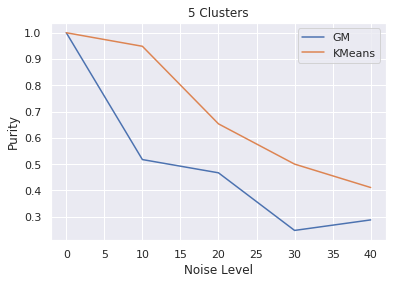

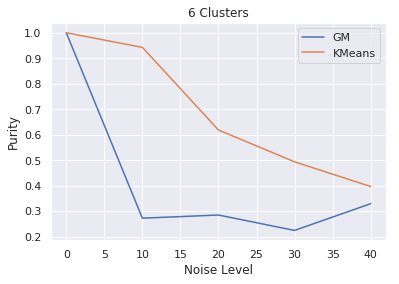

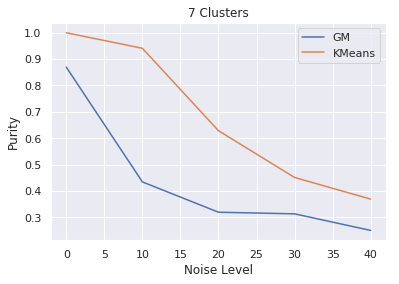

In [68]:
k_means_data =  pd.DataFrame(results, columns=['Number of Clusters', 'Noise', 'Purity'])

gm_list = pk.load( open( "gm_mean_ordering_results", "rb" ) )
gm_data = pd.DataFrame(gm_list, columns=['Number of Clusters', 'Noise', 'Purity'])

for n in cluster_range:
    
    plt.plot('Noise', 'Purity', data = gm_data.loc[gm_data['Number of Clusters'] == n], label='GM')
    plt.plot('Noise', 'Purity', data = k_means_data.loc[gm_data['Number of Clusters'] == n], label='KMeans')
    plt.title(str(n) + ' Clusters')
    plt.xlabel('Noise Level')
    plt.ylabel('Purity')
    plt.legend()
    plt.show()

As seen here, K-Means seems to outperform the graphical model as noise increases and as more clusters are introduced. This is likely that there are too little samples being generated and too many parameters in the model to train for. However, the advantages of using a GM is the flexibility it offers in terms of data clustering. We can specify a specific distribution for each feature. Additionally, it allow us to specify a different variance for each feature. Finally, using weights will allow the GM to not be constrained to relatively equal cluster sizes. All these things only come into play when using real data and thus, there is stil hope that the graphical model can outperform KMeans using real data.

The issue with Max-P is the hyperparameter of the minimum number of areas assigned to a cluster. With real data, we know what this number should be, but in supervised clustering, this number is more ambigous. Additionally, Max-P is very costly to run, and searching for this number is a lot more intense than searching for an optimal number of clusters, as it has a much greater range of values it an assume.